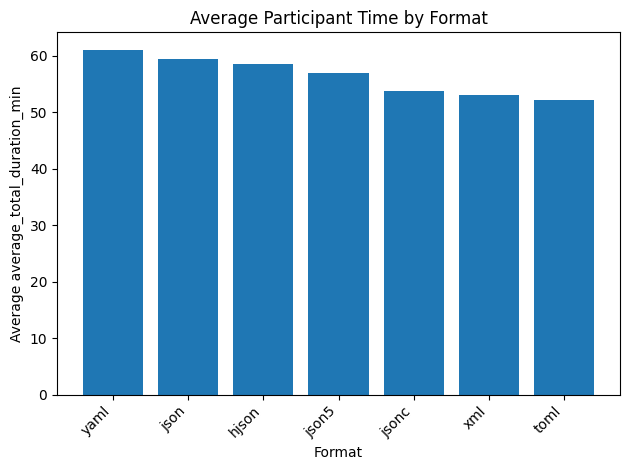

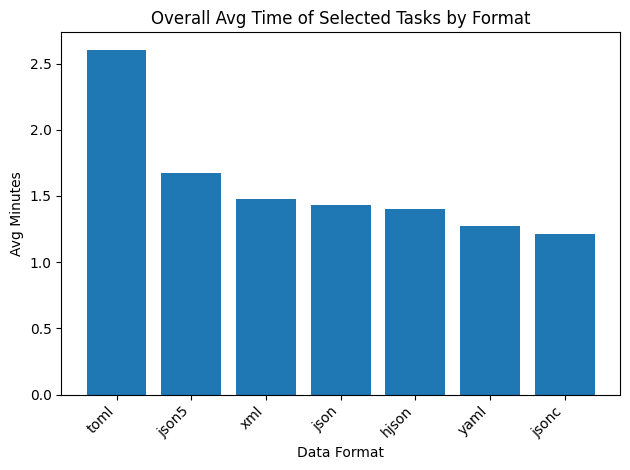

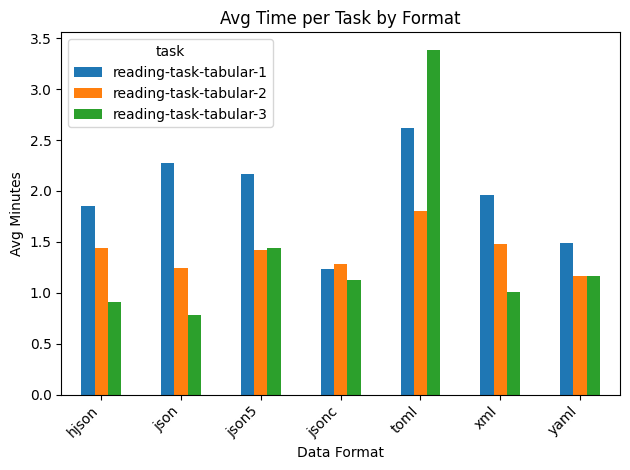

In [3]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

from duration_processor import (
    load_quiz_data,
    extract_format_time,
    sanitize_task_names,
    summarize_participant_by_format,
    plot_participant_time_by_format,
    summarize_tasks_by_format,
    plot_tasks_time_by_format,
    filter_tasks_by_list,
    participant_format_statistics,
    diagnose_all_json
)


# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

# extract format and duration
# df_participant: summarize participant's total time spent by format
df_task, df_participant = extract_format_time(all_data)

# clean 'format' from task name
df_task_clean = sanitize_task_names(df_task)

# average total time spent by format
df_part_summary = summarize_participant_by_format(df_participant)
fig1 = plot_participant_time_by_format(df_part_summary)

# 1. all tasks average time spent by format
task_list=['reading-task-tabular-1', 'reading-task-tabular-2', 'reading-task-tabular-3']
df_filtered = filter_tasks_by_list(df_task_clean, task_list)

df_overall = summarize_tasks_by_format(
    df_task_clean,
    metric='duration_min',
    task_list=task_list,
    mode='overall'
)
fig2 = plot_tasks_time_by_format(
    df_overall,
    metric='average_duration_min',
    mode='overall',
    title='Overall Avg Time of Selected Tasks by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)

# 2. each task average time spent by format
df_by_task = summarize_tasks_by_format(
    df_task_clean,
    task_list=task_list,
    metric='duration_min',
    mode='by_task'
)
fig3 = plot_tasks_time_by_format(
    df_by_task,
    metric='average_duration_min',
    mode='by_task',
    title='Avg Time per Task by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)

In [2]:
df_task

,participantId,task,startTime,endTime,duration_sec,duration_min,format
0,6697c8b6d9d7baa7edd8c4d3,introduction,1745929453052,1745929519521,66.469,1.107817,hjson
1,6697c8b6d9d7baa7edd8c4d3,qualifications,1745929520062,1745929539272,19.210,0.320167,hjson
2,6697c8b6d9d7baa7edd8c4d3,consent,1745929539620,1745929653766,114.146,1.902433,hjson
3,6697c8b6d9d7baa7edd8c4d3,task,1745929653977,1745931386392,1732.415,28.873583,hjson
4,6697c8b6d9d7baa7edd8c4d3,writing-task-NL,1745931386482,1745931539730,153.248,2.554133,hjson
...,...,...,...,...,...,...,...
2723,6675c40cdc52b37294f0514e,modifying-task-tabular-hjson-4,1746235729585,1746235939094,209.509,3.491817,hjson
2724,6675c40cdc52b37294f0514e,modifying-task-tabular-hjson-4_post-task-question,1746235939448,1746235944746,5.298,0.088300,hjson
2725,6675c40cdc52b37294f0514e,$nasa-tlx.co.nasa-tlx,1746235945130,1746235958400,13.270,0.221167,hjson
2726,6675c40cdc52b37294f0514e,post-task-survey-tlx,1746235958794,1746236001871,43.077,0.717950,hjson


In [3]:
df_participant

,participantId,format,total_duration_sec,total_duration_min
0,6697c8b6d9d7baa7edd8c4d3,hjson,4695.463,78.26
1,67e25388d573ec2d5f1c8442,yaml,4214.973,70.25
2,67e5cf90b79d0874e1cf16b0,toml,4366.063,72.77
3,67d00f24466a67ba7e41228e,toml,4482.184,74.70
4,66475d6f7b27e4443ef0d031,json,1200.992,20.02
...,...,...,...,...
83,67ab650c320eccf6141d4010,jsonc,3356.075,55.93
84,65fad673a546ab14baf2f8d3,json5,3510.722,58.51
85,67f1c7bd6f1c4a3d8deae02f,toml,3569.983,59.50
86,67adb27bd5f5776fcb16da62,hjson,3737.170,62.29


In [4]:
loaded, errors = diagnose_all_json(folder)

all JSON files: 88
Successfully parsed: 88
Parsing failed (0)：
 []


In [4]:
format_counts = participant_format_statistics(df_participant)
print(format_counts)

Total number of valid participants: 102
format
json     17
hjson    15
yaml     15
jsonc    15
toml     14
xml      14
json5    12
Name: count, dtype: int64


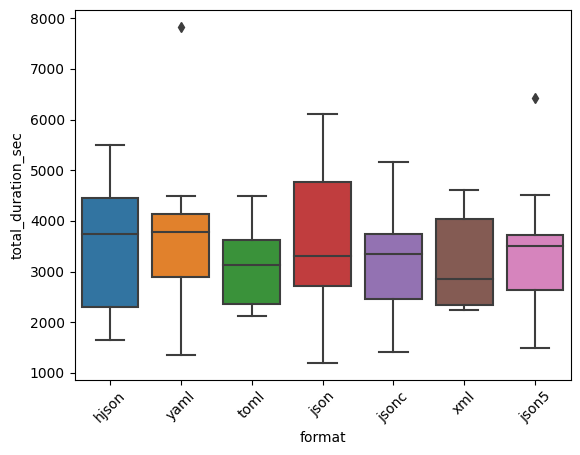

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='format', y='total_duration_sec', data=df_participant)
plt.xticks(rotation=45)
plt.show()


In [7]:
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 假设你已经有一个 DataFrame df_participant，包含列 ['participantId', 'format', 'total_duration_min']

# 1. 检查各组方差齐性（Levene 检验）
groups = [g['total_duration_min'].values for _, g in df_participant.groupby('format')]
stat_levene, p_levene = levene(*groups)
print(f"Levene test: W = {stat_levene:.3f}, p = {p_levene:.3f}")

# 2. 根据 Levene 结果选择检验方法
if p_levene > 0.05:
    # 方差齐性，使用经典的一元 ANOVA
    stat_anova, p_anova = f_oneway(*groups)
    print(f"One-way ANOVA: F = {stat_anova:.3f}, p = {p_anova:.3f}")
    
    # 若总体差异显著，还可以做事后两两比较（Tukey HSD）
    tukey = pairwise_tukeyhsd(endog=df_participant['total_duration_min'],
                              groups=df_participant['format'],
                              alpha=0.05)
    print(tukey)
else:
    # 方差不齐，使用非参数检验（Kruskal–Wallis）
    stat_kw, p_kw = kruskal(*groups)
    print(f"Kruskal–Wallis H = {stat_kw:.3f}, p = {p_kw:.3f}")

# 3. （可选）使用 statsmodels 官方 ANOVA 表格输出
#    这个方法在样本量略有差别时仍然可以使用 Welch 修正：
model = ols('total_duration_min ~ C(format)', data=df_participant).fit()
anova_results = anova_lm(model, typ=2)   # typ=2 表示 Type II ANOVA
print("\nStatsmodels ANOVA table:")
print(anova_results)


Levene test: W = 0.456, p = 0.839
One-way ANOVA: F = 0.464, p = 0.833
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
 hjson   json   1.0064    1.0 -19.9041 21.9169  False
 hjson  json5  -1.5495    1.0  -24.411  21.312  False
 hjson  jsonc   -4.744 0.9943 -26.2981 16.8101  False
 hjson   toml  -6.3425  0.976 -28.2781 15.5931  False
 hjson    xml  -5.3903 0.9896 -27.3259 16.5452  False
 hjson   yaml   2.5907 0.9998 -18.9634 24.1447  False
  json  json5  -2.5559 0.9999 -24.8118 19.6999  False
  json  jsonc  -5.7504 0.9814 -26.6609 15.1601  False
  json   toml  -7.3489 0.9435 -28.6525 13.9547  False
  json    xml  -6.3968  0.971 -27.7003 14.9068  False
  json   yaml   1.5842    1.0 -19.3263 22.4947  False
 json5  jsonc  -3.1945 0.9996  -26.056  19.667  False
 json5   toml   -4.793  0.996 -28.0146 18.4286  False
 json5    xml  -3.8408 0.9988 -27.0624 19.3808  False
 json5   yam

In [15]:
import pandas as pd
import re
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def process_task_data(df_task: pd.DataFrame) -> pd.DataFrame:
    """
    输入原始 df_task，输出处理后包含：
     - 原始每条 task（task_group = task）
     - 三类 tabular 聚合行
     - tutorial-<format>-part* 聚合行
    返回列: ['participantId','task_group','format','duration_min']
    """
    df = df_task[['participantId','task','duration_min','format']].copy()
    df = df[~df['task'].str.endswith('_post-task-question')]
    df = df[df['task'] != 'unqualified']
    
    # 原始行：task_group = 原 task
    df_orig = df.rename(columns={'task':'task_group'})[['participantId','task_group','format','duration_min']]
    
    agg_frames = []
    # --- 1) tabular 三大聚合 ---
    for prefix in ['modifying-task-tabular','reading-task-tabular','writing-task-tabular']:
        mask = df['task'].str.startswith(prefix + '-')
        if mask.any():
            tmp = (
                df[mask]
                .groupby(['participantId','format'], as_index=False)['duration_min']
                .sum()
            )
            tmp['task_group'] = prefix
            agg_frames.append(tmp[['participantId','task_group','format','duration_min']])
    
    # --- 2) tutorial-<format>-part* 聚合 ---
    tut_mask = df['task'].str.match(r'^tutorial-([^-]+)-part\d+$')
    if tut_mask.any():
        df_tut = df[tut_mask].copy()
        df_tut['task_group'] = df_tut['task'].str.replace(r'-part\d+$','', regex=True)
        tmp2 = (
            df_tut
            .groupby(['participantId','format','task_group'], as_index=False)['duration_min']
            .sum()
        )
        agg_frames.append(tmp2[['participantId','task_group','format','duration_min']])
    
    # 合并
    df_combined = pd.concat([df_orig] + agg_frames, ignore_index=True)
    return df_combined


def test_format_duration(df_combined: pd.DataFrame, task_list: list):
    """
    对 df_combined 中指定的 task_list（支持带后缀的 raw 名称）做组间显著性检验：
     - 方差齐性 → ANOVA or Kruskal
     - ANOVA 时输出 Tukey HSD
    打印并返回结果字典。
    """
    results = {}
    for raw in task_list:
        # 规约 raw → canonical
        canonical = raw
        for prefix in ['modifying-task-tabular','reading-task-tabular','writing-task-tabular']:
            if raw.startswith(prefix + '-'):
                canonical = prefix
                break
        else:
            if re.match(r'^tutorial-[^-]+-part\d+$', raw):
                canonical = re.sub(r'-part\d+$','', raw)
        
        sub = df_combined[df_combined['task_group'] == canonical]
        if sub.empty:
            print(f"⚠️ 任务 “{raw}”（规约为“{canonical}”）无数据，跳过。")
            continue
        
        formats = sub['format'].unique()
        if len(formats) < 2:
            print(f"⚠️ 任务 “{raw}”（{canonical}）只有 1 个 format：{formats.tolist()}，跳过。")
            continue
        
        # 分组取 duration_min
        groups = [g['duration_min'].values for _, g in sub.groupby('format')]
        w, p_levene = levene(*groups)
        
        if p_levene > 0.05:
            stat, pval = f_oneway(*groups)
            method = 'ANOVA'
        else:
            stat, pval = kruskal(*groups)
            method = 'Kruskal–Wallis'
        
        tukey = None
        if method == 'ANOVA':
            tukey = pairwise_tukeyhsd(endog=sub['duration_min'],
                                      groups=sub['format'],
                                      alpha=0.05)
        
        # 打印结果
        print(f"\n=== 原任务: {raw} → 使用组: {canonical} ===")
        print(f"Levene: W={w:.3f}, p={p_levene:.3f}")
        if method == 'ANOVA':
            print(f"One-way ANOVA: F={stat:.3f}, p={pval:.3f}")
            print(tukey)
        else:
            print(f"Kruskal–Wallis: H={stat:.3f}, p={pval:.3f}")
        print('-'*40)
        
        results[raw] = {
            'canonical': canonical,
            'method': method,
            'stat': stat,
            'p_value': pval,
            'levene': (w, p_levene),
            'tukey': tukey
        }
    return results

def generate_interpretation(results: dict) -> dict:
    """
    根据 test_format_duration 的输出，自动生成每个任务的中文解读。
    返回一个 {raw_task: interpretation_str} 的字典。
    """
    interpretations = {}
    for raw, info in results.items():
        cano = info['canonical']
        w, p_levene = info['levene']
        method = info['method']
        stat = info['stat']
        pval = info['p_value']
        
        # 开头
        text = [f"=== 任务 “{raw}”（聚合为“{cano}”）===\n"]
        
        # 方差齐性解读
        if p_levene > 0.05:
            text.append(f"Levene 检验 p = {p_levene:.3f} (>0.05)，组内方差齐性假设成立。\n")
        else:
            text.append(f"Levene 检验 p = {p_levene:.3f} (≤0.05)，组内方差齐性假设不成立；后续使用 {method}。\n")
        
        # 均值差异检验解读
        if method == 'ANOVA':
            text.append(f"One-way ANOVA 结果: F = {stat:.3f}, p = {pval:.3f}。\n")
            if pval < 0.05:
                text.append("→ p < 0.05，拒绝“各格式均值相等”原假设，说明组间存在显著差异。\n")
                text.append("  建议查看 Tukey HSD 事后比较以确定哪两组差异显著。\n")
            else:
                text.append("→ p ≥ 0.05，无法拒绝原假设，不同格式耗时无显著差异。\n")
        else:
            text.append(f"Kruskal–Wallis 结果: H = {stat:.3f}, p = {pval:.3f}。\n")
            if pval < 0.05:
                text.append("→ p < 0.05，拒绝原假设，说明组间存在显著差异。\n")
            else:
                text.append("→ p ≥ 0.05，不同格式耗时无显著差异。\n")
        
        interpretations[raw] = ''.join(text)
    return interpretations



In [16]:
# 1) 先跑预处理
df_proc = process_task_data(df_task)
df_proc

,participantId,task_group,format,duration_min
0,6697c8b6d9d7baa7edd8c4d3,introduction,hjson,1.107817
1,6697c8b6d9d7baa7edd8c4d3,qualifications,hjson,0.320167
2,6697c8b6d9d7baa7edd8c4d3,consent,hjson,1.902433
3,6697c8b6d9d7baa7edd8c4d3,task,hjson,28.873583
4,6697c8b6d9d7baa7edd8c4d3,writing-task-NL,hjson,2.554133
...,...,...,...,...
2341,67f1a4f8dd44e7cd5adffa29,tutorial-json5,json5,11.771167
2342,67f1c7bd6f1c4a3d8deae02f,tutorial-toml,toml,9.815200
2343,67f3619e16d4ca195fbd1bd0,tutorial-yaml,yaml,5.680300
2344,67f5bb69760b211cdfe8021c,tutorial-jsonc,jsonc,4.624967


In [17]:
tasks = [
    'modifying-task-tabular',
    'reading-task-tabular',
    'writing-task-tabular',
    'modifying-task-tabular-1'
    # …按需添加
]
res = test_format_duration(df_proc, tasks)


# 3. 自动生成解读
interpretations = generate_interpretation(res)
for raw, txt in interpretations.items():
    print(txt)



=== 原任务: modifying-task-tabular → 使用组: modifying-task-tabular ===
Levene: W=0.428, p=0.859
One-way ANOVA: F=1.342, p=0.246
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
 hjson   json    0.495    1.0  -7.8965  8.8865  False
 hjson  json5  -0.8794    1.0 -10.0538  8.2951  False
 hjson  jsonc  -2.7633 0.9607  -11.413  5.8865  False
 hjson   toml  -2.2234  0.988 -11.0263  6.5795  False
 hjson    xml   0.0675    1.0  -8.7354  8.8704  False
 hjson   yaml   4.4793 0.7077  -4.1705 13.1291  False
  json  json5  -1.3744 0.9992 -10.3058   7.557  False
  json  jsonc  -3.2583 0.9037 -11.6498  5.1332  False
  json   toml  -2.7184 0.9616 -11.2676  5.8309  False
  json    xml  -0.4275    1.0  -8.9768  8.1217  False
  json   yaml   3.9843 0.7841  -4.4072 12.3758  False
 json5  jsonc  -1.8839 0.9961 -11.0584  7.2906  False
 json5   toml   -1.344 0.9995  -10.663  7.9749  False
 json5    xm